# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
# @markdown # Install OpenFace

"""
    refernce:
        https://gist.github.com/jcheong0428/c16146b386ea60fab888b56e8e5ee747
"""

# Uninstall the current CUDA version
!echo [1/6] Uninstall CUDA
!apt-get --purge remove cuda nvidia* libnvidia-* &> /dev/null
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge &> /dev/null
!apt-get remove cuda-* &> /dev/null
!apt autoremove &> /dev/null
!apt-get update &> /dev/null

# Download CUDA 10.0
!echo [2/6] Download and Install CUDA 10.0
!wget -q --no-clobber https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
# install CUDA kit dpkg
!yes | dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb > /dev/null
!echo [3/6] Install CUDA
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub &> /dev/null
!apt-get update &> /dev/null
!apt-get -q install cuda-10-0 &> /dev/null
# Slove libcurand.so.10 error
!wget --no-clobber http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb &> /dev/null
# -nc, --no-clobber: skip downloads that would download to existing files.
!apt -q install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb &> /dev/null
!apt-get update &> /dev/null

# clone openface
!echo [4/6] Clone OpenFace
!git clone -q --depth 1 https://github.com/TadasBaltrusaitis/OpenFace.git

# Install new CMake becaue of CUDA10
!echo [5/6] Install CMake and GCC
!wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
!tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# Get newest GCC
!sudo apt-get update &> /dev/null
!sudo apt-get -q install build-essential &> /dev/null
!sudo apt-get -q install g++-8 &> /dev/null


# Finally, actually install OpenFace
!echo [6/6] Install OpenFace
!cd OpenFace && bash ./download_models.sh && sudo bash ./install.sh &> /dev/null

## Utils

In [ ]:
import cv2
import numpy as np

def frames_to_video(frames_dir, output_path):
    filenames = [f for f in os.listdir(frames_dir) if 
                 f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    filenames = sorted(filenames)
    
    first_frame = cv2.imread(os.path.join(frames_dir, filenames[0]))
    h, w, _ = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video = cv2.VideoWriter(output_path, fourcc, 30, (w,h))
    
    for filename in filenames:
        video.write(cv2.imread(os.path.join(frames_dir, filename)))

    video.release()
    cv2.destroyAllWindows()

    print(f'Successfully generated! {output_path}')

In [ ]:
import csv

def pspi_text_to_csv(pspi_true_dir, output_csv):
    filenames = [f for f in os.listdir(pspi_true_dir) if f.lower().endswith('.txt')]
    filenames = sorted(filenames)

    frame_num = np.arange(len(filenames))
    pspi = []
    for filename in filenames:
        with open(os.path.join(pspi_true_dir, filename), 'r') as txt_file:
            p = txt_file.readline()
            pspi.append(p)

    rows = zip(frame_num, pspi)
    with open(output_csv, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(('frame_num', 'gt_pspi'))
        for row in rows:
            writer.writerow(row)

    print(f'Ground Truth PSPI csv file saved to {output_csv}')


def aus_to_pspi(aus):
    """ Compute PSPI from AU intensities
        PSPI = AU_4 + max(AU_6,AU_7) + max(AU_9,AU_10) + AU_43
        
        Input:
            aus: a list of AU intensities
                * use AU_45 (blink) instead of AU_43 (eyes_closed)
                * list values in increasing order of the unit number
                  0:4, 1:6, 2:7, 3:9, 4:10, 5:45
        Output:
            PSPI score in float
    """
    term_1 = aus[0]
    term_2 = max(aus[1], aus[2])
    term_3 = max(aus[3], aus[4])
    term_4 = 0 if round(aus[5])==0 else 1

    pspi = term_1 + term_2 + term_3 + term_4

    return round(pspi, 2)


def plot_pspi(pspi_true_csv, pspi_pred_csv, save_path, display=False):
    true_df = pd.read_csv(pspi_true_csv)
    pred_df = pd.read_csv(pspi_pred_csv)
    x = true_df['frame_num']
    y_true = true_df['gt_pspi']
    y_pred = pred_df['PSPI_from_AU']

    plt.plot(x, y_true, label='Ground Truth')
    plt.plot(x, y_pred, label='PSPI from AU')
    plt.ylim((0,15))
    plt.yticks(np.arange(16))
    plt.xlabel('Frames')
    plt.ylabel('PSPI')

    plt.legend(loc='upper right')

    plt.savefig(save_path)

    if display:
        plt.show()
    else:
        plt.close()

# Data

In [ ]:
#@markdown #Load *UNBC-McMaster shoulder pain* Dataset

!mkdir -p './dataset/UNBCMcMaster/'
!cp '/gdrive/MyDrive/datasets/UNBC-McMaster/Frame_Labels.zip' './dataset/UNBCMcMaster/'
!cp '/gdrive/MyDrive/datasets/UNBC-McMaster/Images.zip' './dataset/UNBCMcMaster/'
!unzip -q './dataset/UNBCMcMaster/Frame_Labels.zip' -d './dataset/UNBCMcMaster/'
!unzip -q './dataset/UNBCMcMaster/Images.zip' -d './dataset/UNBCMcMaster/'

In [ ]:
dataset_dir = '/content/dataset/UNBCMcMaster/' #@param {type: 'string'}
patient_name = '064-ak064' #@param {type: 'string'}
sequence_name = 'ak064t1aaaff' #@param {type: 'string'}

test_name = 'test-64-1' #@param {type: 'string'}

!mkdir -p /content/results_patient_vid
!mkdir -p /content/results_au_vid
!mkdir -p /content/output_video
!mkdir -p /content/output_pspi
!mkdir -p /content/plot_pspi

import os 

img_dir = os.path.join(dataset_dir, 'Images', patient_name, sequence_name)
gt_pspi_dir = os.path.join(dataset_dir, 'Frame_Labels/PSPI', patient_name, sequence_name)

# frames_to_video output will be saved here:
vid_data_path = f'/content/dataset/{test_name}.mp4'
# OpenFace results will be saved here:
results_dir = f'/content/{test_name}_openface-results'
# path to OpenFace .avi output:
avi_path = f'{results_dir}/{test_name}.avi'

# My results
result_data_dir =  f'/content/{test_name}_results'
!mkdir -p $result_data_dir

# pspi calculated from AUs will be saved here:
pspi_path = f'{result_data_dir}/{test_name}_pspi.csv'
# pspi plot will be saved here:
plot_pspi_path = f'{result_data_dir}/{test_name}_pspi.png'
# pspi_text_to_csv output will be saved here:
gt_pspi_csv = f'/content/dataset/gt-pspi_{test_name}.csv'
# OpenFace processed patient mp4 will be saved here:
patient_vid = f'{result_data_dir}/{test_name}_openface.mp4'
# AU histogram animation will be saved here:
au_vid = f'{result_data_dir}/{test_name}_au.mp4'
# PSPI from AU histogram animation will be saved here:
pspi_vid = f'{result_data_dir}/{test_name}_pspi.mp4'
# horizontally stacked video will be saved here:
output_vid = f'{result_data_dir}/{test_name}_out.mp4'


print(f'        img_dir: {img_dir}')
print(f'    gt_pspi_dir: {gt_pspi_dir}')
print(f'  vid_data_path: {vid_data_path}')
print(f'    results_dir: {results_dir}')
print(f'       avi_path: {avi_path}\n')

print(f'result_data_dir: {result_data_dir}')
print(f'      pspi_path: {pspi_path}')
print(f' plot_pspi_path: {plot_pspi_path}')
print(f'    gt_pspi_csv: {gt_pspi_csv}')
print(f'    patient_vid: {patient_vid}')
print(f'         au_vid: {au_vid}')
print(f'       pspi_vid: {pspi_vid}')
print(f'     output_vid: {output_vid}')

        img_dir: /content/dataset/UNBCMcMaster/Images/064-ak064/ak064t1aaaff
    gt_pspi_dir: /content/dataset/UNBCMcMaster/Frame_Labels/PSPI/064-ak064/ak064t1aaaff
  vid_data_path: /content/dataset/test-64-1.mp4
    results_dir: /content/test-64-1_openface-results
       avi_path: /content/test-64-1_openface-results/test-64-1.avi

result_data_dir: /content/test-64-1_results
      pspi_path: /content/test-64-1_results/test-64-1_pspi.csv
 plot_pspi_path: /content/test-64-1_results/test-64-1_pspi.png
    gt_pspi_csv: /content/dataset/gt-pspi_test-64-1.csv
    patient_vid: /content/test-64-1_results/test-64-1_openface.mp4
         au_vid: /content/test-64-1_results/test-64-1_au.mp4
       pspi_vid: /content/test-64-1_results/test-64-1_pspi.mp4
     output_vid: /content/test-64-1_results/test-64-1_out.mp4


# Test

## run OpenFace

In [ ]:
frames_to_video(img_dir, vid_data_path)

Successfully generated! /content/dataset/test-64-1.mp4


In [ ]:
# clear any previous outputs.
!rm -rf $results_dir

# !./OpenFace/build/bin/FaceLandmarkVidMulti -f $vid_data_path -out_dir $results_dir
!./OpenFace/build/bin/FeatureExtraction -aus -tracked -f $vid_data_path -out_dir $results_dir

# convert the result into MP4
!ffmpeg -y -loglevel info -i $avi_path $patient_vid

Could not find the HAAR face detector location
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/main_ceclm_general.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/cen_general.txt
Reading the PDM module from: ./OpenFace/build/bin/model/pdms/In-the-wild_aligned_PDM_68.txt....Done
Reading the Triangulations module from: ./OpenFace/build/bin/model/tris_68.txt....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.25_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.35_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenFace/build/bin/mode

## AU predictions to video

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

csv_path = f'{results_dir}/{test_name}.csv'
fields = ['AU04_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU45_r']

df = pd.read_csv(csv_path, usecols=fields)

fig, ax = plt.subplots()
ax.set_ylim((0,5))
ax.set_xlabel('AU')
ax.set_ylabel('Intensity')

bar_04 = df['AU04_r'][0]
bar_06 = df['AU06_r'][0]
bar_07 = df['AU07_r'][0]
bar_09 = df['AU09_r'][0]
bar_10 = df['AU10_r'][0]
bar_45 = df['AU45_r'][0]
    
bars = plt.bar(['4', '6', '7', '9', '10', '45'],
               [bar_04, bar_06, bar_07, bar_09, bar_10, bar_45], color='orange')

def animate(i):
    h_04 = df['AU04_r'][i]
    h_06 = df['AU06_r'][i]
    h_07 = df['AU07_r'][i]
    h_09 = df['AU09_r'][i]
    h_10 = df['AU10_r'][i]
    h_45 = df['AU45_r'][i]
    h = [h_04, h_06, h_07, h_09, h_10, h_45]
    
    for j, bar in enumerate(bars):
        bar.set_height(h[j])
    ax.set_title(f'Frame #{i}')

frames = len(df)
ani = FuncAnimation(fig, animate, blit=False, 
                    frames=np.arange(frames),
                    interval=33,
                    save_count=frames,
                    )

# %matplotlib inline
# HTML(ani.to_html5_video())

ani.save(f'{au_vid}', writer=animation.FFMpegWriter(fps=30))
plt.close()

## AU-to-PSPI to csv & video

In [ ]:
pspi_text_to_csv(gt_pspi_dir, gt_pspi_csv)

Ground Truth PSPI csv file saved to /content/dataset/gt-pspi_test-64-1.csv


In [ ]:
csv_path = f'{results_dir}/{test_name}.csv'  # openface output
fields = ['AU04_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU45_r']

df = pd.read_csv(csv_path, usecols=fields)
au_seq = df.values.tolist()

pspi = []
for au_fr in au_seq:
    aus = [float(au) for au in au_fr]
    pspi_fr = aus_to_pspi(aus)
    pspi.append(pspi_fr)

df['PSPI_from_AU'] = pspi
df.to_csv(f'{pspi_path}')

In [ ]:
plot_pspi(gt_pspi_csv, pspi_path, plot_pspi_path, display=False)

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

true_df = pd.read_csv(gt_pspi_csv)
df = pd.read_csv(pspi_path, usecols=['PSPI_from_AU'])
frames = len(df)

fig, ax = plt.subplots()
ax.set_ylim((0,15))
ax.set_xlabel('Frame')
ax.set_ylabel('PSPI')

x_true = true_df['frame_num']
y_true = true_df['gt_pspi']

y_from_au = df['PSPI_from_AU']

plt.plot(x_true, y_true, label='Ground Truth')
plt.xlabel('Frames')
plt.ylabel('PSPI')

line_1, = ax.plot(x_true, y_from_au, label='PSPI from AUs')

def update(i, x_true, y_from_au, line_1):
    line_1.set_data(x_true[:i], y_from_au[:i])
    line_1.axes.axis([0, frames, 0, 15])
    line_1.set_label('PSPI from AUs')

    plt.legend(loc='upper right')
    ax.set_title(f'PSPI from AUs: {round(y_from_au[i])}')

    return line_1,


ani = FuncAnimation(fig, update,
                    fargs=[x_true, y_from_au, line_1],
                    blit=False, 
                    frames=np.arange(frames),
                    interval=33,
                    save_count=frames,
                    )

# %matplotlib inline
# HTML(ani.to_html5_video())

ani.save(pspi_vid, writer=animation.FFMpegWriter(fps=30))
plt.close()

## openface + au + pspi to video

In [ ]:
patient_vid_resized = f'{patient_vid[:-4]}-resized.mp4'
au_vid_resized = f'{au_vid[:-4]}-resized.mp4'
pspi_vid_resized = f'{pspi_vid[:-4]}-resized.mp4'

# Resize patient video
!ffmpeg -n -i $patient_vid \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
-c:v libx264 $patient_vid_resized &> /dev/null

# Resize AU histogram video
!ffmpeg -n -i $au_vid \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
    -c:v libx264 $au_vid_resized &> /dev/null

# Resize PSPI histogram video
!ffmpeg -n -i $pspi_vid \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
    -c:v libx264 $pspi_vid_resized &> /dev/null

# hstack patient video (left) & au plot video (right)
!ffmpeg -n -i $patient_vid_resized -i $au_vid_resized -i $pspi_vid_resized -filter_complex hstack=3 $output_vid &> /dev/null

## Downlaod Results to Local

In [ ]:
result_zip = f'/content/{test_name}_results.zip'
!zip -r $result_zip $result_data_dir

from google.colab import files
files.download(result_zip)

  adding: content/test-64-1_results/ (stored 0%)
  adding: content/test-64-1_results/test-64-1_openface-resized.mp4 (deflated 1%)
  adding: content/test-64-1_results/test-64-1_pspi.png (deflated 4%)
  adding: content/test-64-1_results/test-64-1_pspi.csv (deflated 70%)
  adding: content/test-64-1_results/test-64-1_au.mp4 (deflated 8%)
  adding: content/test-64-1_results/test-64-1_pspi-resized.mp4 (deflated 24%)
  adding: content/test-64-1_results/test-64-1_openface.mp4 (deflated 0%)
  adding: content/test-64-1_results/test-64-1_pspi.mp4 (deflated 20%)
  adding: content/test-64-1_results/test-64-1_au-resized.mp4 (deflated 8%)
  adding: content/test-64-1_results/test-64-1_out.mp4 (deflated 1%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# etc: youtube kid

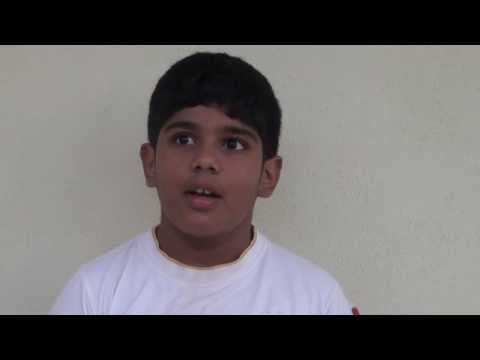

In [ ]:
from IPython.display import YouTubeVideo

# Change the Youtube_ID with the link to your group's video.
YOUTUBE_ID = 'YTKI-nDvKRo'

YouTubeVideo(YOUTUBE_ID)

In [ ]:
!pip install youtube_dl

     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

[youtube] YTKI-nDvKRo: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 39.10MiB in 10:35


In [ ]:
# trim video
!ffmpeg -y -loglevel info -i youtube.mp4 -ss 00:00:44 -t 10 /content/youtube_video.mp4
# clear any previous outputs.
!rm -rf youtube_results
# detect poses on the these 10 seconds.
!./OpenFace/build/bin/FaceLandmarkVidMulti -f youtube_video.mp4 -out_dir youtube_results
# convert the result into MP4
!ffmpeg -y -loglevel info -i /content/youtube_results/youtube_video.avi youtube_output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

csv_path = '/content/youtube_results/youtube_video.csv'
fields = ['AU04_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU45_r']

df = pd.read_csv(csv_path, usecols=fields)

fig, ax = plt.subplots()
ax.set_ylim((0,5))
ax.set_xlabel('AU')
ax.set_ylabel('Intensity')

bar_04 = df['AU04_r'][0]
bar_06 = df['AU06_r'][0]
bar_07 = df['AU07_r'][0]
bar_09 = df['AU09_r'][0]
bar_10 = df['AU10_r'][0]
bar_45 = df['AU45_r'][0]
    
bars = plt.bar(['4', '6', '7', '9', '10', '45'],
               [bar_04, bar_06, bar_07, bar_09, bar_10, bar_45], color='orange')

def animate(i):
    h_04 = df['AU04_r'][i]
    h_06 = df['AU06_r'][i]
    h_07 = df['AU07_r'][i]
    h_09 = df['AU09_r'][i]
    h_10 = df['AU10_r'][i]
    h_45 = df['AU45_r'][i]
    h = [h_04, h_06, h_07, h_09, h_10, h_45]
    
    for j, bar in enumerate(bars):
        bar.set_height(h[j])
    ax.set_title(f'Frame #{i}')

frames = len(df)
ani = FuncAnimation(fig, animate, blit=False, 
                    frames=np.arange(frames),
                    interval=33,
                    save_count=frames,
                    )

# %matplotlib inline
# HTML(ani.to_html5_video())

ani.save('/content/yt_au.mp4', writer=animation.FFMpegWriter(fps=30))
plt.close()

In [ ]:
csv_path = '/content/youtube_results/youtube_video.csv'
fields = ['AU04_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU45_r']

df = pd.read_csv(csv_path, usecols=fields)
au_seq = df.values.tolist()

pspi = []
for au_fr in au_seq:
    aus = [float(au) for au in au_fr]
    pspi_fr = aus_to_pspi(aus)
    pspi.append(pspi_fr)

df['PSPI_from_AU'] = pspi
df.to_csv('/content/yt_pspi.csv')

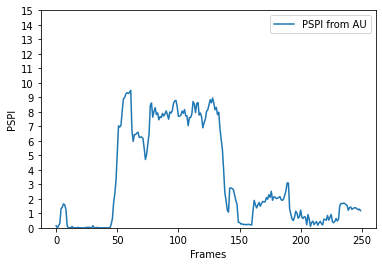

In [ ]:
pred_df = pd.read_csv('/content/yt_pspi.csv')

x = np.arange(len(pred_df))
y_pred = pred_df['PSPI_from_AU']

plt.plot(x, y_pred, label='PSPI from AU')
plt.ylim((0,15))
plt.yticks(np.arange(16))
plt.xlabel('Frames')
plt.ylabel('PSPI')
plt.legend(loc='upper right')

plt.savefig('/content/yt_pspi_plt.png')

plt.show()

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/yt_pspi.csv', usecols=['PSPI_from_AU'])
frames = len(df)

fig, ax = plt.subplots()
ax.set_ylim((0,15))
ax.set_xlabel('Frame')
ax.set_ylabel('PSPI')

x_from_au = np.arange(frames)
y_from_au = df['PSPI_from_AU']

plt.xlabel('Frames')
plt.ylabel('PSPI')

line_1, = ax.plot(x_from_au, y_from_au, label='PSPI from AUs')

def update(i, x_from_au, y_from_au, line_1):
    line_1.set_data(x_from_au[:i], y_from_au[:i])
    line_1.axes.axis([0, frames, 0, 15])
    line_1.set_label('PSPI from AUs')

    plt.legend(loc='upper right')
    ax.set_title(f'PSPI from AUs: {round(y_from_au[i])}')

    return line_1,


ani = FuncAnimation(fig, update,
                    fargs=[x_from_au, y_from_au, line_1],
                    blit=False, 
                    frames=np.arange(frames),
                    interval=33,
                    save_count=frames,
                    )

# %matplotlib inline
# HTML(ani.to_html5_video())

ani.save('/content/yt_pspi.mp4', writer=animation.FFMpegWriter(fps=30))
plt.close()

In [ ]:
# Resize patient video
!ffmpeg -n -i '/content/youtube_output.mp4' \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
-c:v libx264 '/content/youtube_output-resized.mp4' &> /dev/null

# Resize AU histogram video
!ffmpeg -n -i '/content/yt_au.mp4' \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
    -c:v libx264 '/content/yt_au-resized.mp4' &> /dev/null

# Resize PSPI histogram video
!ffmpeg -n -i '/content/yt_pspi.mp4' \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
    -c:v libx264 '/content/yt_pspi-resized.mp4' &> /dev/null

# hstack patient video (left) & au plot video (right)
!ffmpeg -n -i '/content/youtube_output-resized.mp4' -i '/content/yt_au-resized.mp4' \
    -i '/content/yt_pspi-resized.mp4' -filter_complex hstack=3 '/content/yt_out.mp4' &> /dev/null

In [ ]:
from google.colab import files
files.download('/content/yt_out.mp4')
files.download('/content/yt_pspi_plt.png')
files.download('/content/yt_pspi.csv')
# files.download('/content/yt_pspi.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>